# Circuit

> SAX Circuits

In [1]:
from functools import partial

import sax
from sax.circuit import _create_dag, _draw_dag, _find_root, _find_leaves, _validate_models, _flat_circuit

Let's start by creating a simple recursive netlist with gdsfactory.

:::{note}
We are using gdsfactory to create our netlist because it allows us to see the circuit we want to simulate and because we're striving to have a compatible netlist implementation in SAX.

However... gdsfactory is not a dependency of SAX. You can also define your circuits by hand (see [SAX Quick Start](../examples/01_quick_start.ipynb) or you can use another tool to programmatically construct your netlists.
:::

2023-09-03 17:26:17.153 | WARNING  | gdsfactory.pdk:get_active_pdk:714 - No active PDK. Activating generic PDK.



2023-09-03 17:26:17.316 | INFO     | gdsfactory.technology.layer_views:__init__:790 - Importing LayerViews from YAML file: '/opt/conda/lib/python3.10/site-packages/gdsfactory/generic_tech/layer_views.yaml'.


2023-09-03 17:26:17.317 | INFO     | gdsfactory.pdk:activate:333 - 'generic' PDK is now active


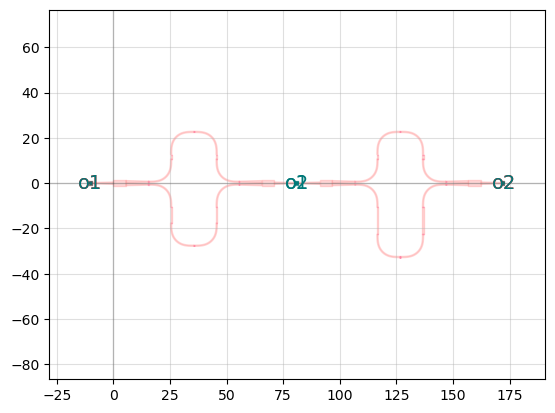

In [2]:
import gdsfactory as gf
from IPython.display import display
from gdsfactory.components import mzi
from gdsfactory.get_netlist import get_netlist_recursive, get_netlist, get_netlist_yaml
from gdsfactory.quickplotter import quickplot


@gf.cell
def twomzi():
    c = gf.Component()

    # instances
    mzi1 = mzi(delta_length=10)
    mzi2 = mzi(delta_length=20)

    # references
    mzi1_ = c << mzi1
    mzi2_ = c << mzi2

    # connections
    mzi2_.connect("o1", mzi1_.ports["o2"])

    # ports
    c.add_port("o1", port=mzi1_.ports["o1"])
    c.add_port("o2", port=mzi2_.ports["o2"])
    return c


comp = twomzi()
quickplot(comp)
recnet = sax.RecursiveNetlist.parse_obj(
    get_netlist_recursive(
        comp, get_netlist_func=partial(get_netlist, full_settings=True)
    )
)
flatnet = recnet.__root__["mzi_delta_length10"]

To be able to model this device we'll need some SAX dummy models:

In [3]:
def bend_euler(
    angle=90.0,
    p=0.5,
    # cross_section="strip",
    # direction="ccw",
    # with_bbox=True,
    # with_arc_floorplan=True,
    # npoints=720,
):
    return sax.reciprocal({
        ('o1', 'o2'): 1.0
    })

In [4]:
def mmi1x2(
    width=0.5,
    width_taper= 1.0,
    length_taper= 10.0,
    length_mmi= 5.5,
    width_mmi= 2.5,
    gap_mmi= 0.25,
    # cross_section= strip,
    # taper= {function= taper},
    # with_bbox= True,
):
    return sax.reciprocal({
        ('o1', 'o2'): 0.45**0.5,
        ('o1', 'o3'): 0.45**0.5,
    })

In [5]:
def mmi2x2(
    width=0.5,
    width_taper= 1.0,
    length_taper= 10.0,
    length_mmi= 5.5,
    width_mmi= 2.5,
    gap_mmi= 0.25,
    # cross_section= strip,
    # taper= {function= taper},
    # with_bbox= True,
):
    return sax.reciprocal({
        ('o1', 'o3'): 0.45**0.5,
        ('o1', 'o4'): 1j * 0.45**0.5,
        ('o2', 'o3'): 1j * 0.45**0.5,
        ('o2', 'o4'): 0.45**0.5,
    })

In [6]:
def straight(
    length=0.01,
    #npoints=2,
    #with_bbox=True,
    #cross_section=...
):
    return sax.reciprocal({
        ('o1', 'o2'): 1.0
    })

In SAX, we usually aggregate the available models in a models dictionary:

In [7]:
models = {
    'straight': straight,
    'bend_euler': bend_euler,
    'mmi1x2': mmi1x2,
}

We can also create some dummy multimode models:

In [8]:
def bend_euler_mm(
    angle=90.0,
    p=0.5,
    # cross_section="strip",
    # direction="ccw",
    # with_bbox=True,
    # with_arc_floorplan=True,
    # npoints=720,
):
    return sax.reciprocal({
        ('o1@TE', 'o2@TE'): 0.9**0.5,
        #('o1@TE', 'o2@TM'): 0.01**0.5,
        #('o1@TM', 'o2@TE'): 0.01**0.5,
        ('o1@TM', 'o2@TM'): 0.8**0.5,
    })

In [9]:
def mmi1x2_mm(
    width=0.5,
    width_taper= 1.0,
    length_taper= 10.0,
    length_mmi= 5.5,
    width_mmi= 2.5,
    gap_mmi= 0.25,
    # cross_section= strip,
    # taper= {function= taper},
    # with_bbox= True,
):
    return sax.reciprocal({
        ('o1@TE', 'o2@TE'): 0.45**0.5,
        ('o1@TE', 'o3@TE'): 0.45**0.5,
        ('o1@TM', 'o2@TM'): 0.41**0.5,
        ('o1@TM', 'o3@TM'): 0.41**0.5,
        ('o1@TE', 'o2@TM'): 0.01**0.5,
        ('o1@TM', 'o2@TE'): 0.01**0.5,
        ('o1@TE', 'o3@TM'): 0.02**0.5,
        ('o1@TM', 'o3@TE'): 0.02**0.5,
    })

In [10]:
def straight_mm(
    length=0.01,
    #npoints=2,
    #with_bbox=True,
    #cross_section=...
):
    return sax.reciprocal({
        ('o1@TE', 'o2@TE'): 1.0,
        ('o1@TM', 'o2@TM'): 1.0,
    })

In [11]:
models_mm = {
    'straight': straight_mm,
    'bend_euler': bend_euler_mm,
    'mmi1x2': mmi1x2_mm,
}

We can now represent our recursive netlist model as a Directed Acyclic Graph:

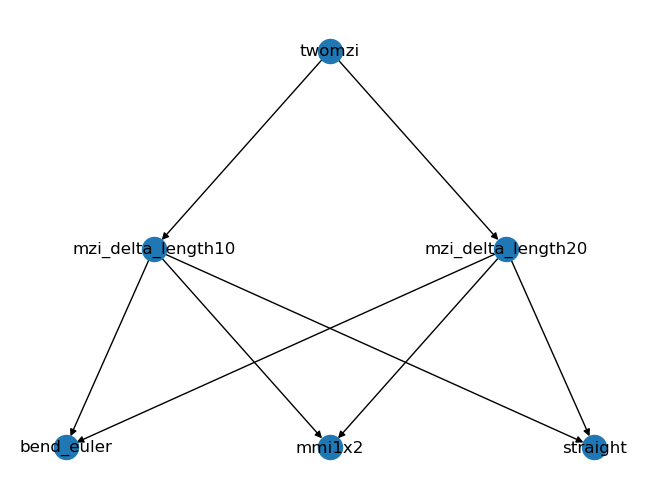

In [12]:
dag = _create_dag(recnet, models)
_draw_dag(dag)

Note that the DAG depends on the models we supply. We could for example stub one of the sub-netlists by a pre-defined model:

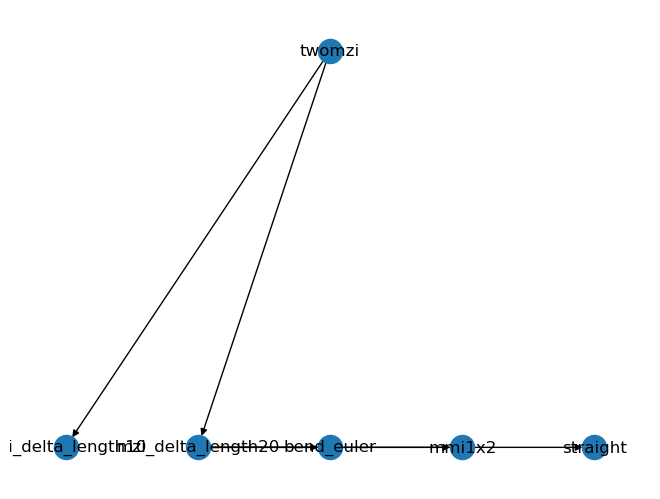

In [13]:
dag_ = _create_dag(recnet, {**models, 'mzi_delta_length10': mmi2x2})
_draw_dag(dag_, with_labels=True)

This is useful if we for example pre-calculated a certain model.

We can easily find the root of the DAG:

In [14]:
_find_root(dag)

['twomzi']

Similarly we can find the leaves:

In [15]:
_find_leaves(dag)

['bend_euler', 'mmi1x2', 'straight']

To be able to simulate the circuit, we need to supply a model for each of the leaves in the dependency DAG. Let's write a validator that checks this

In [16]:
models = _validate_models(models, dag)

We can now dow a bottom-up simulation. Since at the bottom of the DAG, our circuit is always flat (i.e. not hierarchical) we can implement a minimal `_flat_circuit` definition, which only needs to work on a flat (non-hierarchical circuit):

In [17]:
flatnet = recnet.__root__["mzi_delta_length10"]
single_mzi = _flat_circuit(
    flatnet.instances,
    flatnet.connections,
    flatnet.ports,
    models,
    "default",
)
single_mzi()

(Array([[0. +0.j, 0.9+0.j],
        [0.9+0.j, 0. +0.j]], dtype=complex128),
 {'o1': 0, 'o2': 1})

The resulting circuit is just another SAX model (i.e. a python function) returing an SType:

In [18]:
single_mzi?

Let's 'execute' the circuit:

Note that we can also supply multimode models:

In [19]:
flatnet = recnet.__root__["mzi_delta_length10"]
single_mzi = _flat_circuit(
    flatnet.instances,
    flatnet.connections,
    flatnet.ports,
    models_mm,
    "default",
)
single_mzi()

(Array([[0.        +0.j, 0.        +0.j, 0.7482    +0.j, 0.23011426+0.j],
        [0.        +0.j, 0.        +0.j, 0.23011426+0.j, 0.5491    +0.j],
        [0.7482    +0.j, 0.23011426+0.j, 0.        +0.j, 0.        +0.j],
        [0.23011426+0.j, 0.5491    +0.j, 0.        +0.j, 0.        +0.j]],      dtype=complex128),
 {'o1@TE': 0, 'o1@TM': 1, 'o2@TE': 2, 'o2@TM': 3})

Now that we can handle flat circuits the extension to hierarchical circuits is not so difficult:

single mode simulation:

In [20]:
double_mzi, info = sax.circuit(recnet, models, backend='default')
double_mzi()

{('o1', 'o1'): Array(0.+0.j, dtype=complex128),
 ('o1', 'o2'): Array(0.81+0.j, dtype=complex128),
 ('o2', 'o1'): Array(0.81+0.j, dtype=complex128),
 ('o2', 'o2'): Array(0.+0.j, dtype=complex128)}

multi mode simulation:

In [21]:
double_mzi, info = sax.circuit(recnet, models_mm, backend='default', return_type='sdict')
double_mzi()

{('o1@TE', 'o1@TE'): Array(0.+0.j, dtype=complex128),
 ('o1@TE', 'o1@TM'): Array(0.+0.j, dtype=complex128),
 ('o1@TE', 'o2@TE'): Array(0.61275581+0.j, dtype=complex128),
 ('o1@TE', 'o2@TM'): Array(0.29852723+0.j, dtype=complex128),
 ('o1@TM', 'o1@TE'): Array(0.+0.j, dtype=complex128),
 ('o1@TM', 'o1@TM'): Array(0.+0.j, dtype=complex128),
 ('o1@TM', 'o2@TE'): Array(0.29852723+0.j, dtype=complex128),
 ('o1@TM', 'o2@TM'): Array(0.35446338+0.j, dtype=complex128),
 ('o2@TE', 'o1@TE'): Array(0.61275581+0.j, dtype=complex128),
 ('o2@TE', 'o1@TM'): Array(0.29852723+0.j, dtype=complex128),
 ('o2@TE', 'o2@TE'): Array(0.+0.j, dtype=complex128),
 ('o2@TE', 'o2@TM'): Array(0.+0.j, dtype=complex128),
 ('o2@TM', 'o1@TE'): Array(0.29852723+0.j, dtype=complex128),
 ('o2@TM', 'o1@TM'): Array(0.35446338+0.j, dtype=complex128),
 ('o2@TM', 'o2@TE'): Array(0.+0.j, dtype=complex128),
 ('o2@TM', 'o2@TM'): Array(0.+0.j, dtype=complex128)}

sometimes it's useful to get the required circuit model names to be able to create the circuit:

In [22]:
sax.get_required_circuit_models(recnet, models)

['mzi_delta_length10', 'mzi_delta_length20']